# Data retrieval

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

%matplotlib inline

In [2]:
url = 'https://inshorts.com/en/read/technology'

In [3]:
news_data = []

In [4]:
news_category = url.split('/')
news_category

['https:', '', 'inshorts.com', 'en', 'read', 'technology']

In [5]:
news_category = news_category[-1]

In [6]:
data = requests.get(url)
data.content

b'<!doctype html>\n<html lang="en">\n\n<head>\n  <meta charset="utf-8" />\n  <style>\n    /* The Modal (background) */\n    .modal_contact {\n        display: none; /* Hidden by default */\n        position: fixed; /* Stay in place */\n        z-index: 8; /* Sit on top */\n        left: 0;\n        top: 0;\n        width: 100%; /* Full width */\n        height: 100%;\n        overflow: auto; /* Enable scroll if needed */\n        background-color: rgb(0,0,0); /* Fallback color */\n        background-color: rgba(0,0,0,0.4); /* Black w/ opacity */\n    }\n\n    /* Modal Content/Box */\n    .modal-content {\n        background-color: #fefefe;\n        margin: 15% auto;\n        padding: 20px !important;\n        padding-top: 0 !important;\n        /* border: 1px solid #888; */\n        text-align: center;\n        position: relative;\n        border-radius: 6px;\n    }\n\n    /* The Close Button */\n    .close {\n      left: 90%;\n      color: #aaa;\n      float: right;\n      font-size: 

In [7]:
soup = BeautifulSoup(data.content, 'html.parser')

In [8]:
news_articles = [{'news_headline': headline.find('span', attrs={'itemprop': 'headline'}).string,
                  'news_article': article.find('div', attrs={'itemprop': 'articleBody'}).string,
                  'news_category': news_category} 
                 for headline, article in zip(soup.find_all('div', 
                                                            class_ = ['news-card-title news-right-box']), 
                                              soup.find_all('div', class_=['news-card-content news-right-box']))]

In [9]:
news_data.extend(news_articles)
news_data

[{'news_article': "TRAI has issued a strict warning to all entities, who need to send out bulk messages to customers, to register their templates for the same. Entities that don't comply with the telemarketing rules within three days, will be barred from sending commercial SMSes, it said. TRAI suspended the new norms for a week on Tuesday after disruptions in SMS operations.",
  'news_category': 'technology',
  'news_headline': 'Comply with bulk SMS norms within 3 days or be barred: TRAI to cos'},
 {'news_article': 'Bitcoin, the world\'s biggest cryptocurrency, crossed $60,000 for the first time after hitting an all-time high of $60,012 briefly on Saturday. This cryptocurrency has seen a big rise after Elon Musk\'s Tesla invested $1.5 billion in it, while Twitter CEO Jack Dorsey and rapper Jay-Z said they are creating a fund aimed at making Bitcoin "the internet\'s currency".',
  'news_category': 'technology',
  'news_headline': 'Bitcoin hits record high, crosses $60,000 for the first 

In [10]:
df = pd.DataFrame(news_data)

In [11]:
df = df[['news_headline', 'news_article', 'news_category']]

In [12]:
df.head(5)

,news_headline,news_article,news_category
0,Comply with bulk SMS norms within 3 days or be...,TRAI has issued a strict warning to all entiti...,technology
1,"Bitcoin hits record high, crosses $60,000 for ...","Bitcoin, the world's biggest cryptocurrency, c...",technology
2,Ant Group CEO Simon Hu resigns due to 'persona...,China's Ant Group CEO Simon Hu has resigned fr...,technology
3,"Bitcoin surges past $59,000 to hit a new recor...","Bitcoin surpassed $59,000 to hit a new record ...",technology
4,Elon Musk's erratic tweets cost Tesla billions...,"A Tesla investor has sued Elon Musk, alleging ...",technology


In [13]:
df.shape

(25, 3)

# Prepare user defined function to extract data from inshorts.com

In [14]:
urls_list = ['https://inshorts.com/en/read/technology',
             'https://inshorts.com/en/read/sports',
             'https://inshorts.com/en/read/world']

In [15]:
def datasetPrepare(urls_list):
    news_data = []
    for url in urls_list:
        news_category = url.split('/')[-1]
        data = requests.get(url)
        soup = BeautifulSoup(data.content, 'html.parser')
        news_articles = [{'news_headline': headline.find('span', attrs={"itemprop": "headline"}).string,
                          'news_article': article.find('div', attrs={"itemprop": "articleBody"}).string,
                          'news_category': news_category}
                         
                            for headline, article in 
                             zip(soup.find_all('div', class_=["news-card-title news-right-box"]),
                                 soup.find_all('div', class_=["news-card-content news-right-box"]))
                        ]
        news_data.extend(news_articles) 
    df =  pd.DataFrame(news_data)
    df = df[['news_headline', 'news_article', 'news_category']]
    return df    

In [16]:
news_df = datasetPrepare(urls_list)

In [17]:
news_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74 entries, 0 to 73
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   news_headline  74 non-null     object
 1   news_article   74 non-null     object
 2   news_category  74 non-null     object
dtypes: object(3)
memory usage: 1.9+ KB


In [18]:
news_df.head(5)

,news_headline,news_article,news_category
0,"Bitcoin hits record high, crosses $60,000 for ...","Bitcoin, the world's biggest cryptocurrency, c...",technology
1,China denies plan for near $1 bn fine on Aliba...,Chinese market regulator has refuted a Wall St...,technology
2,Comply with bulk SMS norms within 3 days or be...,TRAI has issued a strict warning to all entiti...,technology
3,"Bitcoin surges past $59,000 to hit a new recor...","Bitcoin surpassed $59,000 to hit a new record ...",technology
4,Not in talks with Tesla for EV charging statio...,Tata Power has denied being in talks with Elon...,technology


In [19]:
news_df.news_category.value_counts()

technology    25
sports        25
world         24
Name: news_category, dtype: int64

# Text Wrangling and Pre-processing

In [24]:
import spacy
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
import re
import unicodedata

In [25]:
nlp = spacy.load('en')

In [26]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [27]:
tokenizer = ToktokTokenizer()
stopword_list = nltk.corpus.stopwords.words('english')
stopword_list.remove('no')
stopword_list.remove('not')

## Remove HTML tags

In [28]:
def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text()
    return stripped_text

strip_html_tags('<html><h2>Some important text</h2></html>')

'Some important text'

## Remove accented characters

In [29]:
def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

remove_accented_chars('Sómě Áccěntěd těxt')

'Some Accented text'

## Remove special characters

In [30]:
def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text

In [31]:
remove_special_characters("Well this was fun! What do you think? 123#@!", remove_digits=True)

'Well this was fun What do you think '

## Text lemmatization

In [32]:
def lemmatize_text(text):
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text

In [33]:
lemmatize_text("My system keeps crashing! his crashed yesterday, ours crashes daily")

'My system keep crash ! his crash yesterday , ours crash daily'

## Text stemming

In [34]:
def simple_stemmer(text):
    ps = nltk.porter.PorterStemmer()
    text = ' '.join([ps.stem(word) for word in text.split()])
    return text

simple_stemmer("My system keeps crashing his crashed yesterday, ours crashes daily")

'My system keep crash hi crash yesterday, our crash daili'

## Remove stopwords

In [35]:
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

remove_stopwords("The, and, if are stopwords, computer is not")

', , stopwords , computer not'

## Building a text normalizer

In [36]:
def normalize_corpus(corpus, html_stripping=True, contraction_expansion=True,
                     accented_char_removal=True, text_lower_case=True, 
                     text_lemmatization=True, special_char_removal=True, 
                     stopword_removal=True, remove_digits=True):
    
    normalized_corpus = []
    # normalize each document in the corpus
    for doc in corpus:
        # strip HTML
        if html_stripping:
            doc = strip_html_tags(doc)
        # remove accented characters
        if accented_char_removal:
            doc = remove_accented_chars(doc)
        # lowercase the text    
        if text_lower_case:
            doc = doc.lower()
        # remove extra newlines
        doc = re.sub(r'[\r|\n|\r\n]+', ' ',doc)
        # lemmatize text
        if text_lemmatization:
            doc = lemmatize_text(doc)
        # remove special characters and\or digits    
        if special_char_removal:
            # insert spaces between special characters to isolate them    
            special_char_pattern = re.compile(r'([{.(-)!}])')
            doc = special_char_pattern.sub(" \\1 ", doc)
            doc = remove_special_characters(doc, remove_digits=remove_digits)  
        # remove extra whitespace
        doc = re.sub(' +', ' ', doc)
        # remove stopwords
        if stopword_removal:
            doc = remove_stopwords(doc, is_lower_case=text_lower_case)
            
        normalized_corpus.append(doc)
        
    return normalized_corpus

## Pre-process and normalize news articles

In [37]:
news_df['full_text'] = news_df["news_headline"].map(str)+ '. ' + news_df["news_article"]

In [38]:
news_df['clean_text'] = normalize_corpus(news_df['full_text'])
norm_corpus = list(news_df['clean_text'])
news_df.iloc[1][['full_text', 'clean_text']].to_dict()

{'clean_text': 'china deny plan near bn fine alibaba monopoly case chinese market regulator refute wall street journal report say plan impose record fine nearly billion jack alibaba suspect anti competitive behaviour not [ website ] not [ true ] state administration market regulation say china launch anti monopoly probe alibaba december',
 'full_text': 'China denies plan for near $1 bn fine on Alibaba in monopoly case. Chinese market regulator has refuted a Wall Street Journal report which said that it was planning to impose a record fine of nearly $1 billion on Jack Ma\'s Alibaba over suspected anti-competitive behaviour. "If it\'s not there [on our website], it\'s not [true]," the State Administration for Market Regulation said. China launched an anti-monopoly probe into Alibaba in December 2020.'}

# Save the news articles

In [39]:
news_df.to_csv('news.csv', index=False, encoding='utf-8')

# Tagging Parts of Speech

In [40]:
news_df = pd.read_csv('news.csv')

In [41]:
news_df.head()

,news_headline,news_article,news_category,full_text,clean_text
0,"Bitcoin hits record high, crosses $60,000 for ...","Bitcoin, the world's biggest cryptocurrency, c...",technology,"Bitcoin hits record high, crosses $60,000 for ...",bitcoin hit record high cross first time bitco...
1,China denies plan for near $1 bn fine on Aliba...,Chinese market regulator has refuted a Wall St...,technology,China denies plan for near $1 bn fine on Aliba...,china deny plan near bn fine alibaba monopoly ...
2,Comply with bulk SMS norms within 3 days or be...,TRAI has issued a strict warning to all entiti...,technology,Comply with bulk SMS norms within 3 days or be...,comply bulk sms norm within day bar trai cos t...
3,"Bitcoin surges past $59,000 to hit a new recor...","Bitcoin surpassed $59,000 to hit a new record ...",technology,"Bitcoin surges past $59,000 to hit a new recor...",bitcoin surge past hit new record high bitcoin...
4,Not in talks with Tesla for EV charging statio...,Tata Power has denied being in talks with Elon...,technology,Not in talks with Tesla for EV charging statio...,not talk tesla ev charge station india tata ta...


In [42]:
type(news_df.iloc[1].news_headline)

str

In [43]:
corpus = normalize_corpus(news_df['full_text'], text_lower_case=False, 
                          text_lemmatization=False, special_char_removal=False)

sentence = str(news_df.iloc[1].news_headline)
sentence_nlp = nlp(sentence)

In [44]:
spacy_pos_tagged = [(word, word.tag_, word.pos_) for word in sentence_nlp]
pd.DataFrame(spacy_pos_tagged, columns=['Word', 'POS tag', 'Tag type'])

,Word,POS tag,Tag type
0,China,NNP,PROPN
1,denies,VBZ,VERB
2,plan,NN,NOUN
3,for,IN,ADP
4,near,IN,SCONJ
5,$,$,SYM
6,1,CD,NUM
7,bn,NN,NOUN
8,fine,JJ,ADJ
9,on,IN,ADP


In [45]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [46]:
nltk.download('maxent_treebank_pos_tagger')

[nltk_data] Downloading package maxent_treebank_pos_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/maxent_treebank_pos_tagger.zip.


True

In [47]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [48]:
nltk_pos_tagged = nltk.pos_tag(sentence.split())

In [49]:
pd.DataFrame(nltk_pos_tagged, columns=['Word', 'POS tag'])

,Word,POS tag
0,China,NNP
1,denies,VBZ
2,plan,NN
3,for,IN
4,near,JJ
5,$1,NNP
6,bn,NN
7,fine,NN
8,on,IN
9,Alibaba,NNP


# Named Entity Recognition

In [50]:
sentence = str(news_df.iloc[0].full_text)

In [51]:
sentence_nlp = nlp(sentence)

In [52]:
print([(word, word.ent_type_) for word in sentence_nlp if word.ent_type_])

[(Bitcoin, 'GPE'), (60,000, 'MONEY'), (first, 'ORDINAL'), (Bitcoin, 'GPE'), (60,000, 'MONEY'), (first, 'ORDINAL'), (60,012, 'MONEY'), (Saturday, 'DATE'), (Elon, 'PERSON'), (Musk, 'PERSON'), ('s, 'PERSON'), (Tesla, 'PRODUCT'), ($, 'MONEY'), (1.5, 'MONEY'), (billion, 'MONEY'), (Twitter, 'ORG'), (Jack, 'PERSON'), (Dorsey, 'PERSON'), (Jay, 'PERSON'), (-, 'PERSON'), (Z, 'PERSON'), (Bitcoin, 'GPE')]


In [53]:
named_entities = []
for sentence in corpus:
    temp_entity_name = ''
    temp_named_entity = None
    sentence = nlp(sentence)
    for word in sentence:
        term = word.text 
        tag = word.ent_type_
        if tag:
            temp_entity_name = ' '.join([temp_entity_name, term]).strip()
            temp_named_entity = (temp_entity_name, tag)
        else:
            if temp_named_entity:
                named_entities.append(temp_named_entity)
                temp_entity_name = ''
                temp_named_entity = None

entity_frame = pd.DataFrame(named_entities, 
                            columns=['Entity Name', 'Entity Type'])

In [54]:
top_entities = (entity_frame.groupby(by=['Entity Name', 'Entity Type'])
                           .size()
                           .sort_values(ascending=False)
                           .reset_index().rename(columns={0 : 'Frequency'}))
top_entities.T.iloc[:,:15]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
Entity Name,US,India,England,Microsoft,Google,Amazon,Kohli,Huawei,two,China,Friday,Bitcoin,first,Virat Kohli,second
Entity Type,GPE,GPE,GPE,ORG,ORG,ORG,PERSON,ORG,CARDINAL,GPE,DATE,GPE,ORDINAL,PERSON,ORDINAL
Frequency,24,21,10,9,9,8,8,7,7,7,6,6,6,6,5


In [55]:
top_entities = (entity_frame.groupby(by=['Entity Type'])
                           .size()
                           .sort_values(ascending=False)
                           .reset_index().rename(columns={0 : 'Frequency'}))
top_entities.T.iloc[:,:15]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
Entity Type,ORG,PERSON,GPE,DATE,CARDINAL,NORP,ORDINAL,MONEY,WORK_OF_ART,PRODUCT,FAC,TIME,LOC,EVENT,LAW
Frequency,160,134,131,71,68,46,22,13,10,9,7,6,4,4,1


# Emotion and Sentiment Analysis

In [56]:
!pip install afinn
from afinn import Afinn

     |████████████████████████████████| 61kB 5.2MB/s 
  Created wheel for afinn: filename=afinn-0.1-cp37-none-any.whl size=53451 sha256=37ab43053c8e070a35853cec432665848d1d7a0d462bbf41f57bebd965767cf7
  Stored in directory: /root/.cache/pip/wheels/b5/1c/de/428301f3333ca509dcf20ff358690eb23a1388fbcbbde008b2
Successfully built afinn


In [57]:
af = Afinn()

In [58]:
sentiment_scores = [af.score(article) for article in corpus]

In [59]:
sentiment_category = ['positive' if score > 0 
                          else 'negative' if score < 0 
                              else 'neutral' 
                                  for score in sentiment_scores]

In [60]:
df = pd.DataFrame([list(news_df['news_category']), sentiment_scores, sentiment_category]).T

In [61]:
df.columns = ['news_category', 'sentiment_score', 'sentiment_category']

In [62]:
df['sentiment_score'] = df.sentiment_score.astype('float')

In [63]:
df.groupby(by=['news_category']).describe()

sentiment_score                                                  
                        count      mean       std   min    25%  50%   75%   max
news_category                                                                  
sports                   25.0  4.120000  6.385661  -4.0   0.00  3.0  8.00  16.0
technology               25.0 -2.920000  6.607571 -21.0  -6.00 -2.0  2.00   6.0
world                    24.0 -4.666667  6.780193 -19.0 -10.25 -4.5  0.25  10.0

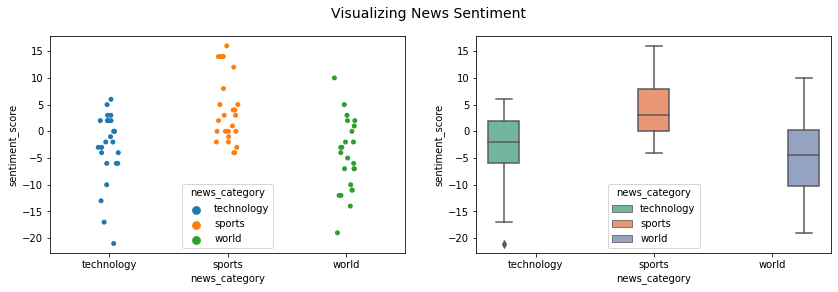

In [64]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
sp = sns.stripplot(x='news_category', y="sentiment_score",  hue='news_category', data=df, ax=ax1)
bp = sns.boxplot(x='news_category', y="sentiment_score", hue='news_category', data=df, palette="Set2", ax=ax2)
t = f.suptitle('Visualizing News Sentiment', fontsize=14)

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


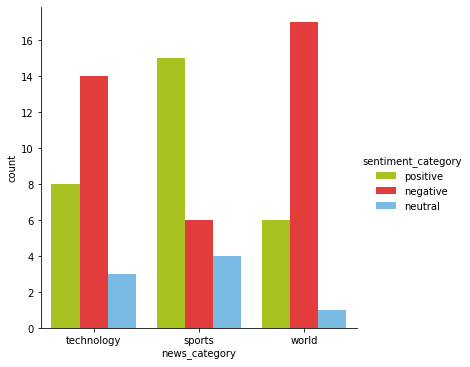

In [65]:
fc = sns.factorplot(x="news_category", hue="sentiment_category", 
                    data=df, kind="count", 
                    palette={"negative": "#FE2020", 
                             "positive": "#BADD07", 
                             "neutral": "#68BFF5"})

In [66]:
pos_idx = df[(df.news_category=='technology') & (df.sentiment_score == 6)].index[0]

In [67]:
neg_idx = df[(df.news_category=='technology') & (df.sentiment_score == -21)].index[0]

In [68]:
print('Most Negative Tech News Article:', news_df.iloc[neg_idx][['news_article']][0])
print()
print('Most Positive Tech News Article:', news_df.iloc[pos_idx][['news_article']][0])

Most Negative Tech News Article: Microsoft CEO Satya Nadella said he's "appalled" by acts of hate against Asian-Americans and the Asian community globally. "Racism...violence have no place in our society. I am united with the Asian and Asian-American community in standing against this injustice," he added. Over 3,000 cases of abuse against Asian-Americans reported between March-December 2020, Asian-American advocacy groups said.

Most Positive Tech News Article: Amazon CEO Jeff Bezos has been invited by Senate Budget Committee Chairman Bernie Sanders to appear before his panel for a hearing on income and wealth inequality. Sanders has also invited an Amazon worker at an Alabama fulfilment centre where some employees are trying to form a union. Sanders plans the hearing for March 17.


In [69]:
df1 = df[df.news_category=='world']
pd.unique(df1.sentiment_score)

array([ -3.,   5.,   2.,  10.,   3.,   1.,  -7., -10.,  -5., -12.,  -2.,
        -6., -11., -14.,   0., -19.,  -4.])

In [71]:
pos_idx = df[(df.news_category=='sports') & (df.sentiment_score == 16)].index[0]
neg_idx = df[(df.news_category=='sports') & (df.sentiment_score == -4)].index[0]

print('Most Negative World News Article:', news_df.iloc[neg_idx][['news_article']][0])
print()
print('Most Positive World News Article:', news_df.iloc[pos_idx][['news_article']][0])

Most Negative World News Article: Ex-England captain Michael Vaughan has said that Team India skipper Virat Kohli, who has scored 0, 62, 27, 0 and 0 in his last five innings, is 10-15 balls away from being back to his usual self. "It will serve the team better if Virat is just a little bit selfish...[and] gives himself ten balls to get in," Vaughan added. 

Most Positive World News Article: FC Goa's Igor Angulo was awarded the Golden Boot and ATK Mohun Bagan's Arindam Bhattacharya won the Golden Glove award on the concluding night of ISL 2020-21 on Saturday. Angulo scored 14 goals this season while Arindam managed 10 clean sheets. ATK Mohun Bagan's Roy Krishna bagged the Hero of the League award for his 14 goals and eight assists. 


In [72]:
from textblob import TextBlob

In [73]:
sentiment_scores_tb = [round(TextBlob(article).sentiment.polarity, 3) for article in news_df['clean_text']]

In [74]:
sentiment_category_tb = ['positive' if score > 0 
                             else 'negative' if score < 0 
                                 else 'neutral' 
                                     for score in sentiment_scores_tb]

In [75]:
df = pd.DataFrame([list(news_df['news_category']), sentiment_scores_tb, sentiment_category_tb]).T
df.columns = ['news_category', 'sentiment_score', 'sentiment_category']
df['sentiment_score'] = df.sentiment_score.astype('float')
df.groupby(by=['news_category']).describe()

sentiment_score                      ...                       
                        count      mean       std  ...    50%      75%    max
news_category                                      ...                       
sports                   25.0  0.171160  0.252837  ...  0.119  0.32000  0.679
technology               25.0  0.029000  0.116544  ...  0.000  0.06800  0.383
world                    24.0  0.021875  0.141746  ...  0.000  0.06525  0.560

[3 rows x 8 columns]

In [76]:
df.head()

,news_category,sentiment_score,sentiment_category
0,technology,0.091,positive
1,technology,0.143,positive
2,technology,0.068,positive
3,technology,0.056,positive
4,technology,0.000,neutral


/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


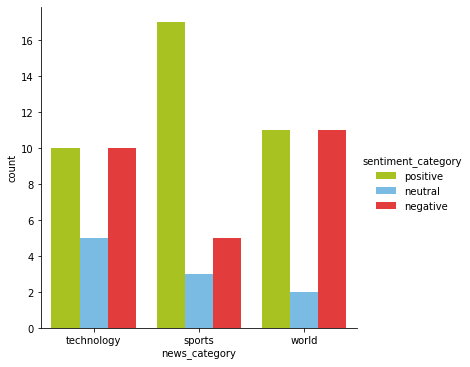

In [77]:
fc = sns.factorplot(x="news_category", hue="sentiment_category", 
                    data=df, kind="count", 
                    palette={"negative": "#FE2020", 
                             "positive": "#BADD07", 
                             "neutral": "#68BFF5"})

In [80]:
pos_idx = df[(df.news_category=='technology') & (df.sentiment_score > 0.)].index[0]
neg_idx = df[(df.news_category=='technology') & (df.sentiment_score < -0.)].index[0]

print('Most Negative World News Article:', news_df.iloc[neg_idx][['news_article']][0])
print()
print('Most Positive World News Article:', news_df.iloc[pos_idx][['news_article']][0])

Most Negative World News Article: China's Ant Group CEO Simon Hu has resigned from the company due to 'personal reasons', the company said on Friday. Hu will be replaced by Executive Chairman Eric Jing, the financial technology giant said on Friday. This comes after Ant's $35 billion initial public offering was abruptly suspended in November last year.

Most Positive World News Article: Bitcoin, the world's biggest cryptocurrency, crossed $60,000 for the first time after hitting an all-time high of $60,012 briefly on Saturday. This cryptocurrency has seen a big rise after Elon Musk's Tesla invested $1.5 billion in it, while Twitter CEO Jack Dorsey and rapper Jay-Z said they are creating a fund aimed at making Bitcoin "the internet's currency".


In [ ]:
import model_evaluation_utils as meu
meu.display_confusion_matrix_pretty(true_labels=sentiment_category, 
                                    predicted_labels=sentiment_category_tb, 
                                    classes=['negative', 'neutral', 'positive'])

ModuleNotFoundError: ignored